In [1]:
import sys

sys.path.append(r"C:\Users\aditya7c\Work Folders\drex\projects\alpha_Fe_deformed\scripts\PMP-main\PMP-main")

In [2]:
import h5py
import numpy as np
import hdf5plugin
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage.morphology import binary_erosion, binary_dilation, disk, skeletonize, remove_small_objects, binary_opening, dilation, medial_axis
from skimage.measure import label, regionprops
from scipy.ndimage import label
from DFXM.image_processor import inv_polefigure_colors 
from DFXM.scan_functions import *

import scipy

In [3]:
def find_grain(image,erosion_steps,radius=1):
    TF = np.isnan(image)
    grain = ~TF
    se = disk(radius, strict_radius=True)
    
    for _ in np.arange(erosion_steps):        
        grain = binary_erosion(grain, se)
    for _ in np.arange(erosion_steps):        
        grain = binary_dilation(grain, se)
    
    return grain

In [4]:
def RGB_image_single(chi_scaled):

    # Create a RGB mosaicity map from the scaled chi and phi images
    # return the RGB image

    mosa = np.stack((chi_scaled, chi_scaled,np.ones_like(chi_scaled)), axis=-1)
    RGB_scaled = mosa.copy()
    RGB_scaled[np.isnan(RGB_scaled)] = 0
    RGB_scaled[RGB_scaled > 1] = 1
    RGB_scaled[RGB_scaled < 0] = 0
    RGB_scaled = colors.hsv_to_rgb(RGB_scaled)

    #RGB_scaled[..., 2] *= 0.75  # reduce the intensity of the blue channel --> this makes things less white (also adapt the scale in chi phi plot)

    return mosa, RGB_scaled

In [5]:

def clean_image(img,minimum,maximum,mask):
    img=np.where(img>maximum,np.nan,img)
    img=np.where(img<minimum,np.nan,img)
    img=np.where(mask,img,np.nan)
    return img


def scale_image(Img):
    
    # Scale the image between 0 and 1
    # return the scaled image

    Min, Max = np.nanmin(Img), np.nanmax(Img)
    scaled_Img = (Img - Min) / (Max - Min)

    return scaled_Img    



def RGB_image(chi_scaled, phi_scaled):

    # Create a RGB mosaicity map from the scaled chi and phi images
    # return the RGB image

    mosa = np.stack((chi_scaled, phi_scaled, np.ones_like(chi_scaled)), axis=-1)
    RGB_scaled = mosa.copy()
    RGB_scaled[np.isnan(RGB_scaled)] = 0
    RGB_scaled[RGB_scaled > 1] = 1
    RGB_scaled[RGB_scaled < 0] = 0
    RGB_scaled = colors.hsv_to_rgb(RGB_scaled)

    #RGB_scaled[..., 2] *= 0.75  # reduce the intensity of the blue channel --> this makes things less white (also adapt the scale in chi phi plot)

    return mosa, RGB_scaled



In [6]:
def calculate_kam_one_motor(chi_img, mask, kernel_size = 2):    
    #chi_img = np.nan_to_num(chi_img, nan=0)
    se = disk(kernel_size, strict_radius=True)
    kam = np.zeros_like(chi_img)
    for ii in range(chi_img.shape[0]):
        for jj in range(chi_img.shape[1]):
            if mask[ii, jj]:
                i_start, i_end = max(ii - kernel_size, 0), min(ii + kernel_size, chi_img.shape[0] - 1)
                j_start, j_end = max(jj - kernel_size, 0), min(jj + kernel_size, chi_img.shape[1] - 1)

                kernel_diff = np.abs(np.nan_to_num(chi_img[i_start:i_end+1, j_start:j_end+1],nan=chi_img[ii, jj]) - chi_img[ii, jj]) 
                kam[ii, jj] = np.sum(kernel_diff) /((i_end - i_start + 1) * (j_end - j_start + 1))
                #if chi_img[ii, jj] != 0:
                #    kam[ii, jj] = kam[ii, jj] / abs(chi_img[ii, jj])
                #else:

                #   kam[ii, jj] = 0  # or any other value that makes sense in your context
    return kam

In [7]:
def calculate_kam(chi_img, phi_img, mask, kernel_size = 2):
    se = disk(kernel_size, strict_radius=True)
    kam = np.zeros_like(chi_img)
    for ii in range(chi_img.shape[0]):
        for jj in range(chi_img.shape[1]):
            if mask[ii, jj]:
                i_start, i_end = max(ii - kernel_size, 0), min(ii + kernel_size, chi_img.shape[0] - 1)
                j_start, j_end = max(jj - kernel_size, 0), min(jj + kernel_size, chi_img.shape[1] - 1)
                good_pixels = ~np.isnan(chi_img[i_start:i_end+1, j_start:j_end+1])
            
                kernel_diff = np.abs(chi_img[i_start:i_end+1, j_start:j_end+1] - chi_img[ii, jj]) + \
                              np.abs(phi_img[i_start:i_end+1, j_start:j_end+1] - phi_img[ii, jj])
    return kam

In [8]:
def boundary_pixels(image,kernel_size = 1):
    se = disk(kernel_size, strict_radius=True)
    dilated_image = binary_dilation(image, se)
    boundary = dilated_image.astype(int) - image.astype(int)
    return boundary


In [9]:
def edit_voids(chi_img,phi_img,mask):
    chi_image=np.where(~mask,1000,chi_img)
    phi_image=np.where(~mask,1000,phi_img)
    return chi_image,phi_img
    

In [10]:
def create_kam_filter(kam, threshold, grain_mask):
    kam_filter = np.zeros_like(kam, dtype=bool)
    kam_filter[grain_mask & (kam > threshold)] = True
    return kam_filter

In [11]:
def remove_small_cell_walls(skel,threshold=5):
    structure = np.ones((3, 3), dtype=int)
    #skel=binary_dilation(skel,disk(1))
    labeled_image, _ = label(skel,structure=structure)
    unique_labels, counts = np.unique(labeled_image, return_counts=True)
    for label_val, count in zip(unique_labels, counts):
        if count < threshold:
            labeled_image[labeled_image == label_val] = 0
    newskel=np.where(labeled_image>0,1,0)
    
    
    return newskel

In [12]:
def remove_bad_cells(labeled_image,minsize=3,maxsize=15):
    label_image=np.copy(labeled_image)
    unique_labels, counts = np.unique(label_image, return_counts=True)
    for label_val, count in zip(unique_labels, counts):
        if count < minsize:
            label_image[label_image == label_val] = 0
        if count > maxsize:
            label_image[label_image == label_val] = 0
    return label_image

In [13]:
def create_skeleton(filter_mask,boundary_pixels, radius=1):
    se = disk(radius)
    #filter_mask = binary_erosion(filter_mask, se)
    #filter_mask = binary_dilation(filter_mask, se)
    #filter_mask = binary_dilation(filter_mask, se)
    
    skel_Img = skeletonize(filter_mask)
    #skel_Img=np.where(boundary_pixels,1,skel_Img)
    skel_Img=skel_Img.astype(bool)
    return skel_Img

In [14]:
def overlay_skeleton(images, skeleton, method='standard'):
    overlaid_images = []
    for img in images:
        if img.ndim == 3:  # For RGB images
            if method == 'method1':
                overlay = np.where(skeleton[..., np.newaxis], [0, 0, 0], img)
            else:  # method2
                overlay = np.copy(img)
                overlay[skeleton] = [0,0,0]
        else:  # For grayscale images
            if method == 'method1':
                overlay = np.where(skeleton, 2.5, img)
            else:  # method2
                overlay = np.where(skeleton, 50, img)
        overlaid_images.append(overlay)

    return overlaid_images

In [15]:
mat_data = scipy.io.loadmat('../scripts/labotex_colormap.mat')
cmap_array = mat_data['map']  # Extract colormap array

# Create a custom colormap in Matplotlib
from matplotlib.colors import ListedColormap
labotex_cmap = ListedColormap(cmap_array)


In [16]:
#### load 65 pct data


datafolder="../../pink_beam/data/50pct_pinkburned_2x_rocking_pDFXM_rci.h5"
with h5py.File (datafolder,'r') as hin:
    print(hin['entry/Peak position'].keys())
    
    chi=hin['entry/Peak position/Peak position'][()]
    fwhm=hin['entry/FWHM/FWHM'][()]
    #fw1=hin['entry/diffry/FWHM/FWHM'][()]
    #fw2=hin['entry/chi/FWHM/FWHM'][()]
    
    

### call motor pos as motor pos 1 or 2 and fw1 and fw2

mp1=chi
fw1=fwhm

#### check histogram and enter the limits of mp1 and fw1

mp1_limlower=85.001
mp1_mean=92
fw1_limupper=7
fw1_limlower=1e-4



### modify after plotting hists

mp1=np.where(mp1<mp1_limlower,np.nan,mp1)
fw1=np.where(fw1>fw1_limupper,np.nan,fw1)
fw1=np.where(fw1<fw1_limlower,np.nan,fw1)

mp1=mp1-mp1_mean
#phi_65=phi_65-125.1
#fw_rms_65=np.sqrt(fw1**2+fw2**2)

<KeysViewHDF5 ['Peak position']>


In [17]:
plt.rcdefaults()

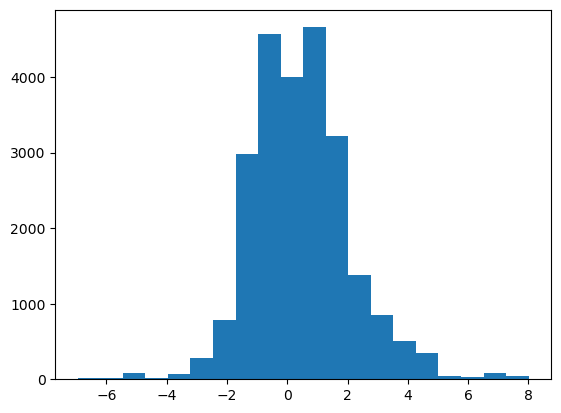

In [18]:
%matplotlib inline
d=np.ravel(mp1)
plt.hist(d,bins=20)
plt.show()


In [19]:
### find grain shape
mask1=find_grain(mp1,1)
#mask2=find_grain(phi_65)



###find grain boundary

boundary1=boundary_pixels(mask1)
#boundary2=boundary_pixels(mask2)


#### clean phi chi images

#phi_50=clean_image(phi_50,-7,7,mask1)
#chi_50=clean_image(chi_50,-7,7,mask1)

#### clean phi chi images

#phi_65=clean_image(phi_65,0,12,mask2)
#chi_65=clean_image(chi_65,0,12,mask2)


### scale phi chi images
mp1_scaled = scale_image(mp1)
fw1_scaled= scale_image(fw1)


### scale phi chi images
#phi_65 = scale_image(phi_65)
#chi_65 = scale_image(chi_65)


### Make mosa maps

#mosa1, Mosa_Img1 = RGB_image(mp1_scaled,fw1_scaled)
mosa2, Mosa_Img2 = RGB_image_single(mp1_scaled)



In [20]:
np.nanmax(mp1)

8.009999999999991

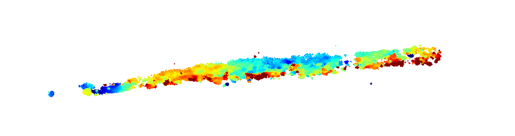

In [21]:
cmap = plt.colormaps.get_cmap("jet")  
norm = plt.Normalize(vmin=-3, vmax=3)
mosa_img = cmap(norm(mp1))  # Returns an RGBA array (NxMx4)

# Convert to 8-bit RGB (0-255)
mosa_img = (mosa_img[:, :, :3] * 255).astype(np.uint8)  # Drop alpha channel
mosa_img[~mask1]=[255,255,255]

# Display
plt.imshow(mosa_img)
plt.axis("off")  # Remove axes
plt.show()

# Now, colored_image_uint8 is your saved colored image array


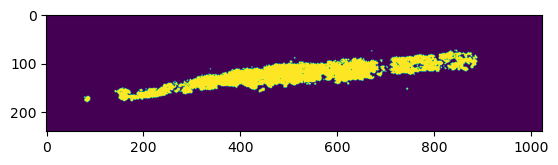

In [22]:
%matplotlib inline

plt.imshow(mask1)
plt.show()

In [23]:
kam1=calculate_kam_one_motor(mp1,mask1,kernel_size=3)
kam2=calculate_kam_one_motor(fw1,mask1,kernel_size=3)

#kam1=np.where(kam1<10e-7,np.nan,kam1)

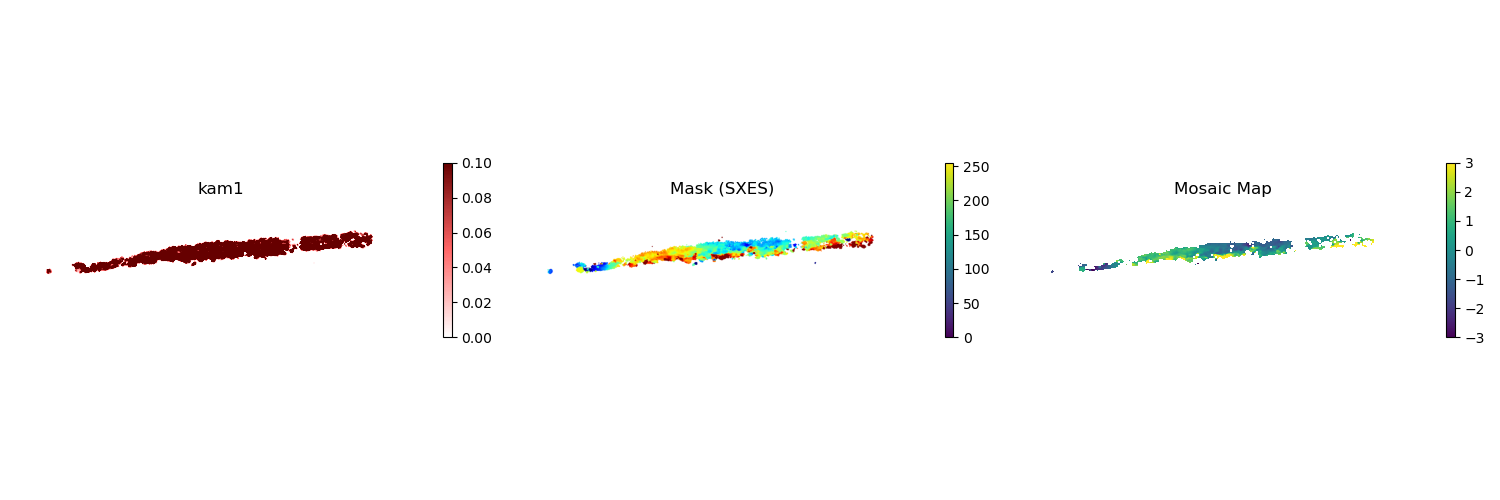

In [24]:

%matplotlib widget  

# Create a figure with 3 subplots, sharing x and y axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot kam1
im1 = axes[0].imshow(kam1, cmap=labotex_cmap, vmin=0.0, vmax=0.1)
axes[0].set_title("kam1")
plt.colorbar(im1, ax=axes[0], fraction=0.02, pad=0.04)

# Plot sxes (mask)
im2 = axes[1].imshow(mosa_img)  # Assuming mask is binary
axes[1].set_title("Mask (SXES)")
plt.colorbar(im2, ax=axes[1], fraction=0.02, pad=0.04)

# Plot Mosa_Img2
im3 = axes[2].imshow(mp1,vmin=-3,vmax=3)  # Use a different colormap for contrast
axes[2].set_title("Mosaic Map")
plt.colorbar(im3, ax=axes[2], fraction=0.02, pad=0.04)

# Remove axis ticks for a cleaner look
for ax in axes:
    ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


In [25]:
kammask1=create_kam_filter(kam1,1,mask1)
kammask2=create_kam_filter(kam2,1,mask1)

skel1=create_skeleton(kammask1,boundary1)
skel2=create_skeleton(kammask2,boundary1)

#### joint skeleton

skel_j=skel1|skel2

In [26]:
from matplotlib.colors import LogNorm

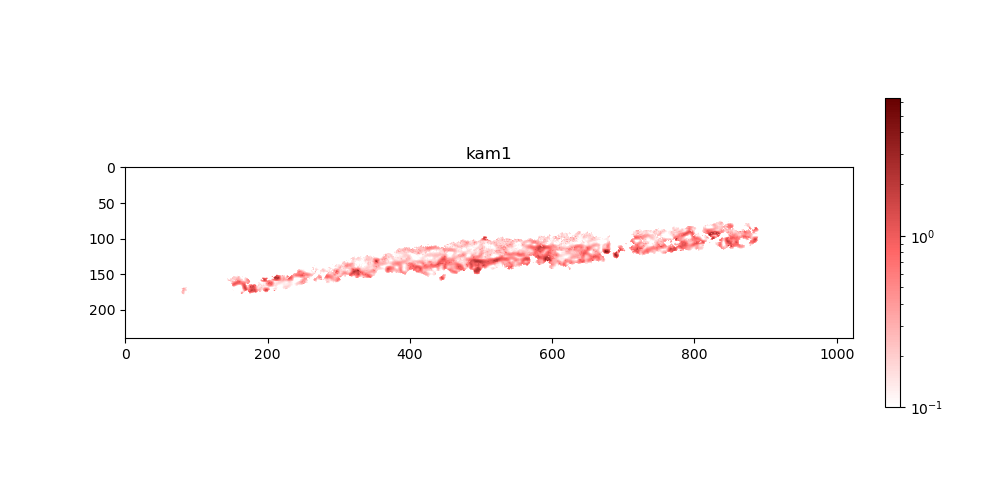

In [27]:

%matplotlib widget  

# Create a figure with 3 subplots, sharing x and y axes
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)

# Plot kam1
im1 = axes.imshow(kam1, cmap=labotex_cmap, norm=LogNorm(vmin=kam1.min() + 1e-1, vmax=kam1.max()))
axes.set_title("kam1")
plt.colorbar(im1, ax=axes, fraction=0.02, pad=0.04)
fig.savefig("kam1_image.png")
plt.show()


In [28]:

def dilate_mask(mask, iterations=1):
    selem = disk(1)
    for _ in range(iterations):
        mask = dilation(mask, selem)
    return mask

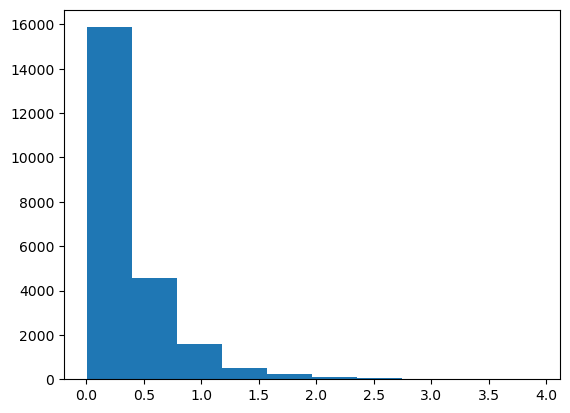

In [30]:
%matplotlib inline
data=np.ravel(kam1)
data=data[data>10e-4]

data=data[data<4]
plt.hist(data)
plt.show()

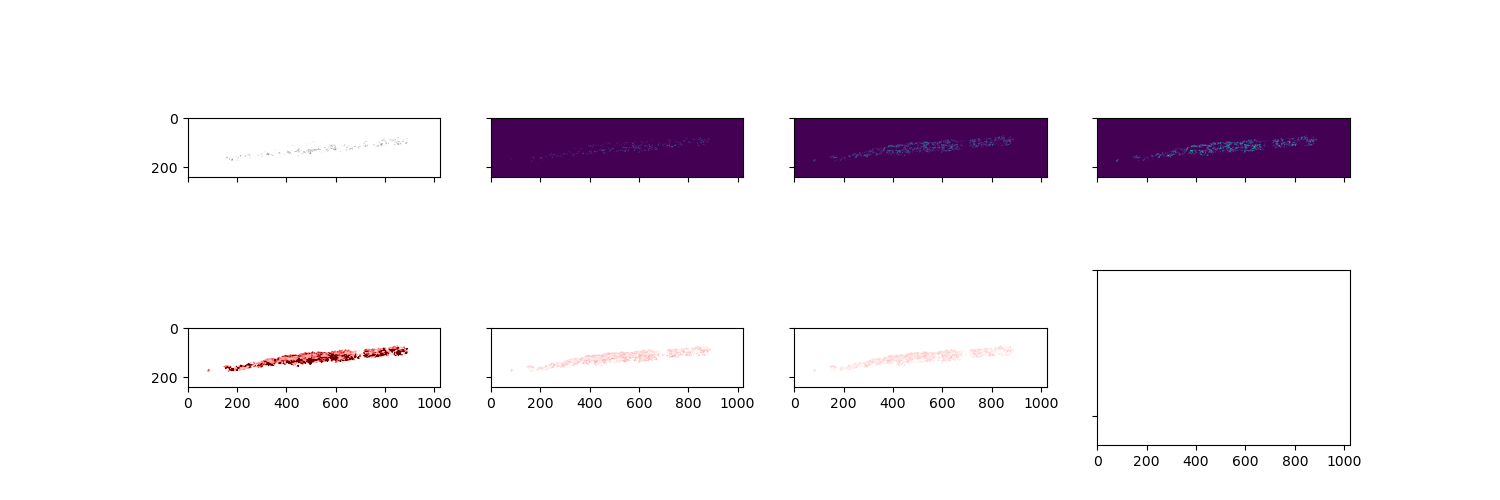

In [31]:

%matplotlib widget
threshold_list=[0.6,0.4,0.2,]

kam1 = calculate_kam_one_motor(mp1, mask1,kernel_size=1)
kammask1 = create_kam_filter(kam1, threshold_list[0], mask1)
skel1 = create_skeleton(kammask1, boundary1)
kammask1_dilated = dilate_mask(kammask1)

# Step 2: Using thresh2
kam2 = np.where(kammask1_dilated,0,kam1)
kammask2=create_kam_filter(kam2,threshold_list[1],mask1)
skel2 = create_skeleton(kammask2, boundary1)
kammask2_dilated = dilate_mask(kammask2)

# Step 3: Using thresh3
kam3 = np.where(kammask2_dilated,0,kam2)
kammask3=create_kam_filter(kam3,threshold_list[2],mask1)
skel3 = create_skeleton(kammask3, boundary1)


# Plotting results
fig, axs = plt.subplots(2, 4, figsize=(15, 5),sharex=True,sharey=True)
axs[0][0].imshow(skel1,cmap='gray_r')
axs[0][1].imshow(skel2)
axs[0][2].imshow(skel3)
axs[1][0].imshow(kam1,cmap=labotex_cmap, vmin=0.0, vmax=0.25)
axs[1][1].imshow(kam2,cmap=labotex_cmap, vmin=0.0, vmax=1)
axs[1][2].imshow(kam3,cmap=labotex_cmap, vmin=0.0, vmax=1)
axs[0][3].imshow(kammask3)

plt.show()


In [32]:
mat_data = scipy.io.loadmat('../mtex_input/data.mat')  # Load MATLAB file
data = mat_data['kam']  
kam_mtex=data.reshape(240,1024)

In [33]:

def process_and_plot(threshold_list,kam, mask1, boundary1, labotex_cmap):
    """
    Process the KAM steps and plot the results for the provided threshold list.
    
    Parameters:
    - threshold_list: List of thresholds to use for filtering.
    - mp1, mask1, boundary1: Input data for the KAM and skeleton processing.
    - labotex_cmap: Colormap for visualizing KAM results.
    """
    skellist = []
    

    # Process each threshold
    for i, threshold in enumerate(threshold_list):
        if i == 0:
            # For the first threshold, use kam as is
            kammask = kam
            kammask = create_kam_filter(kam,threshold, mask1)
            
        else:
            # For subsequent thresholds, use the previous dilated mask
            kammask = create_kam_filter(np.where(kammask, 0, kam), threshold, mask1)
            
        
        skel = create_skeleton(kammask, boundary1)
        skellist.append(skel)
    
    # merge and filter
    mergedskel = skeletonize(np.bitwise_or.reduce(skellist))
    filtered_skel = remove_small_cell_walls(mergedskel, threshold=5)

    return filtered_skel,mergedskel,skellist
    
# Example usage:
kam = kam_mtex
threshold_list = [1,0.5,0.2]  # Or any other list of thresholds
filtered_skel, mergedskel, skellist = process_and_plot(threshold_list,  kam, mask1, boundary1, labotex_cmap)


In [34]:

len(skellist)

3

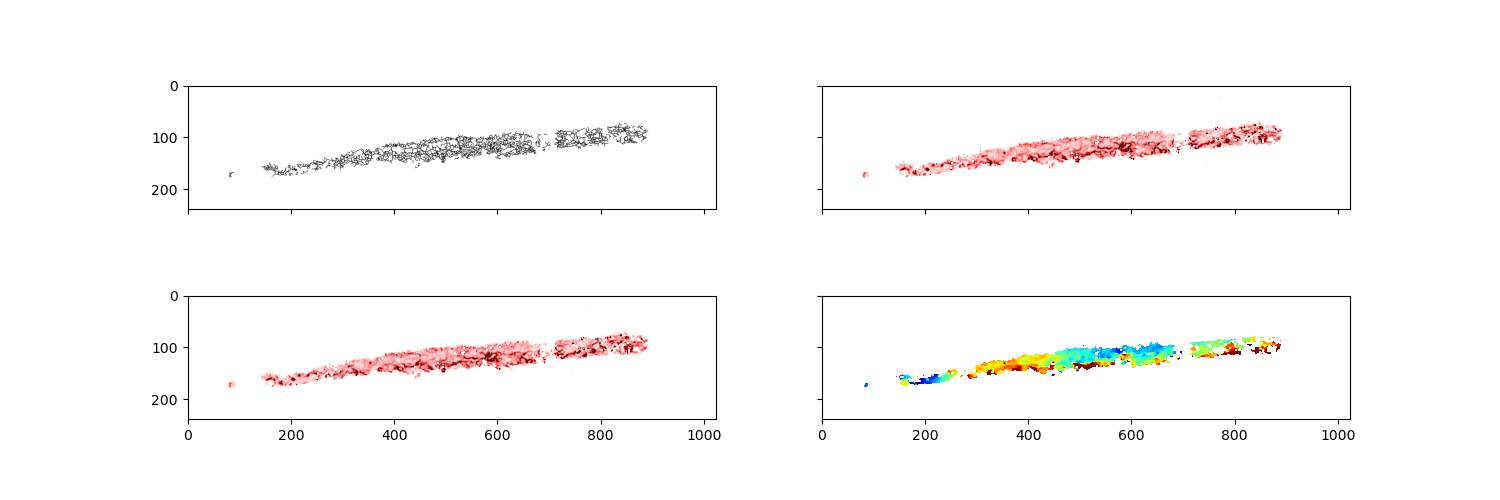

In [35]:
%matplotlib widget
fig, axs = plt.subplots(2, 2, figsize=(15, 5),sharex=True,sharey=True)
axs[0][0].imshow(filtered_skel,cmap='gray_r')
axs[0][1].imshow(kam,cmap=labotex_cmap, vmin=0.0, vmax=1)
axs[1][0].imshow(kam_mtex,cmap=labotex_cmap, vmin=0.0, vmax=1)

axs[1][1].imshow(mp1,vmin=-3,vmax=3,cmap='jet')


plt.show()


In [36]:
#### refine the cell map
filtered_skel=np.where(boundary1,1,filtered_skel)
arraytolabel=~filtered_skel.astype(bool)
labeled_array,counts=ndi.label(arraytolabel)
labeled_array_filtered=remove_bad_cells(labeled_array,3,13000)


print (counts)
print (len(np.unique(labeled_array_filtered))-1)



1372
711


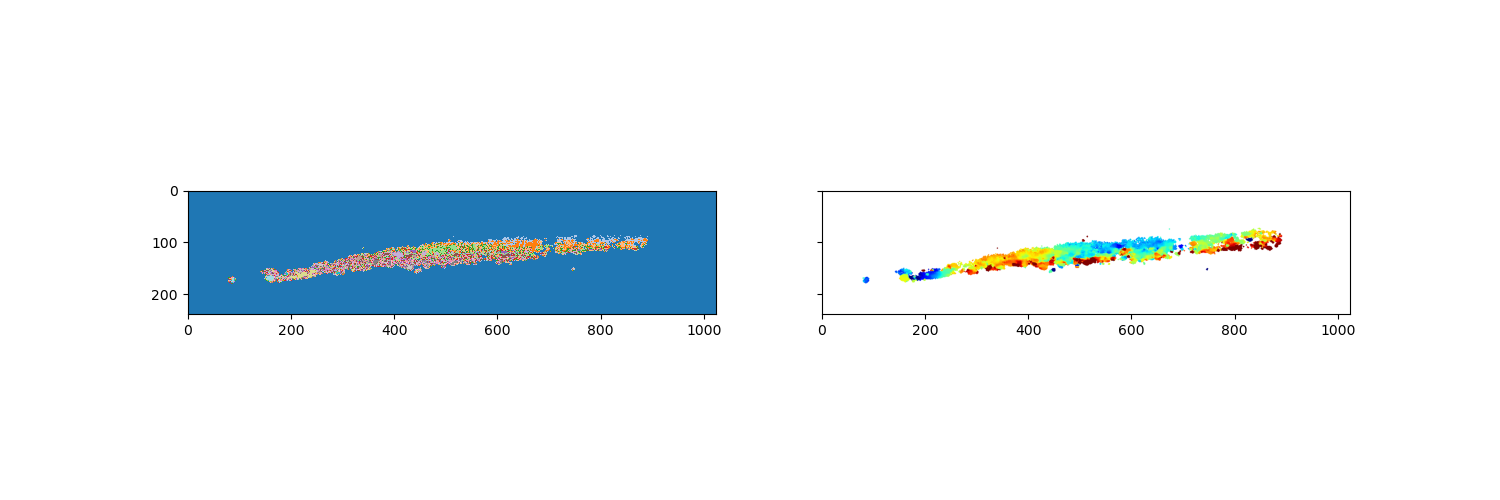

In [37]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=(15, 5),sharex=True,sharey=True)
#axs[0].imshow(labeled_array_filtered1,cmap='tab20')
axs[0].imshow(labeled_array,cmap='tab20')

axs[1].imshow(mosa_img)



plt.show()


In [41]:
np.save('filtered_cells',filtered_skel)

In [42]:
savemat('filtered_cells.mat', {'data': filtered_skel})  # Saves in MATLAB format

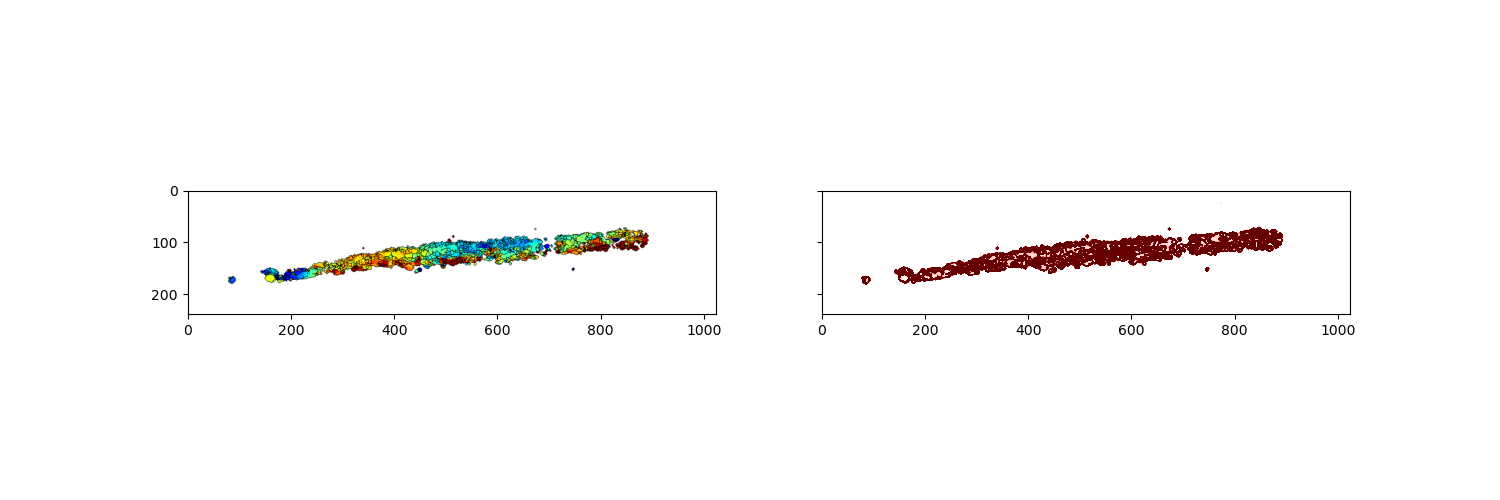

In [43]:
filtered_skel=filtered_skel.astype(bool)
ovi = overlay_skeleton([mosa_img,kam], filtered_skel)

%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=(15, 5),sharex=True,sharey=True)
#axs[0].imshow(labeled_array_filtered1,cmap='tab20')
axs[0].imshow(ovi[0])

axs[1].imshow(ovi[1],cmap=labotex_cmap, vmin=0.0, vmax=1)



plt.show()


In [45]:
areas_micron=areas*0.2260*0.226

In [46]:
np.mean(areas_micron)

0.8980499544159546

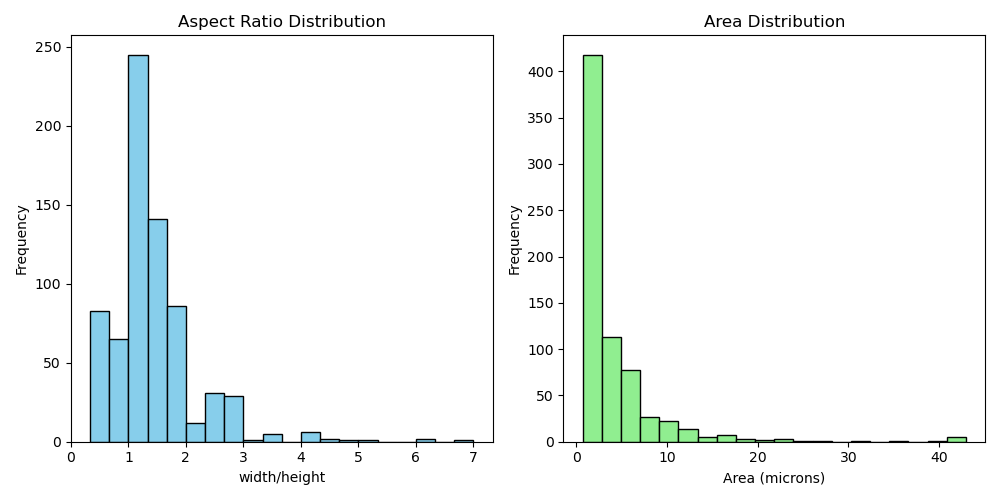

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Label connected regions

# Initialize lists to store aspect ratios and areas
aspect_ratios = []
areas = []

# Iterate through the regions and calculate their aspect ratio and area
for region in regionprops(labeled_array_filtered):
    minr, minc, maxr, maxc = region.bbox  # Bounding box coordinates
    width = maxc - minc
    height = maxr - minr
    aspect_ratio = width / height if height > 0 else width  # Avoid division by zero
    area = region.area
    
    # Store the aspect ratio and area
    aspect_ratios.append(aspect_ratio)
    areas.append(area)

# Convert to numpy arrays for easier analysis
aspect_ratios = np.array(aspect_ratios)
areas = np.array(areas)
areas=areas[areas<200]

# Plotting the aspect ratio distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(aspect_ratios, bins=20, color='skyblue', edgecolor='black')
plt.title('Aspect Ratio Distribution')
plt.xlabel('width/height')
plt.ylabel('Frequency')

# Plotting the area distribution
plt.subplot(1, 2, 2)
plt.hist(areas*0.226, bins=20, color='lightgreen', edgecolor='black')
plt.title('Area Distribution')
plt.xlabel('Area (microns)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('./cell_statistics.png')

plt.show()
